# XGBoost Months: Prediction per Cluster with all Weather Variables & Clusters as an extra Variable

## Loading and Cleaning the Data

### Loading Packages, Datasets & Defining Functions

In [24]:
# Base packages -----------------------------------
import pandas as pd
import numpy as np

# Data Viz -----------------------------------
import matplotlib.pyplot as plt

# XGBoost -------------------------------
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance # built-in function to plot features ordered by their importance

# SKLearn -----------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn import preprocessing # scaling data

In [25]:
# Function that checks if final Output is ready for submission or needs revision   

def check_data(HEX):

    if HEX.shape == (112, 3):
        print(HEX.shape,": Shape is correct.")
    else:
        print(HEX.shape,": Shape is **INCORRECT!**")

    if HEX["CODIGO MUNICIPIO"].nunique() == 112:
        print(HEX["CODIGO MUNICIPIO"].nunique(),": Number of unique municipalities is correct.")
    else:
        print(HEX["CODIGO MUNICIPIO"].nunique(),": Number of unique municipalities is **INCORRECT!**")
    
    print("The Total 2020 Nests' Prediction is", int(HEX["NIDOS 2020"].sum()))

In [26]:
# Importing datasets from GitHub as Pandas Dataframes
queen_train = pd.read_csv("../Feeder_months/WBds03_QUEENtrain_months_DataWig.csv") #2018+2019 test df
queen_predict = pd.read_csv("../Feeder_months/WBds03_QUEENpredict_months_DataWig.csv") #2020 prediction df
queen_clusters = pd.read_csv("../../../Other_open_data/cluster.csv")

### Further Clean the Data

In [27]:
# Adding cluster labels

queen_train = pd.merge(queen_train, queen_clusters, how = 'left', left_on = 'municip_code', right_on = 'CODIGO MUNICIPIO')
queen_predict = pd.merge(queen_predict, queen_clusters, how = 'left', left_on = 'municip_code', right_on = 'CODIGO MUNICIPIO')

In [28]:
# Remove the Municipalities that we did not assign a Cluster since there was not reliable data for us to predict 

queen_train = queen_train.loc[~queen_train.municip_code.isin([48071, 48074, 48022, 48088, 48051, 48020]),:].copy()
queen_predict = queen_predict.loc[~queen_predict.municip_code.isin([48071, 48074, 48022, 48088, 48051, 48020]),:].copy()

## Generate a ML Model for Each Cluster

### Scale the Data to extract Feature Importance for Each Cluster

#### Arrange data into a features matrix and target vector

In [29]:
# selecting the train X & y variables

# Y will be the response variable (filter for the number of wasp nests - waspbust_id)  
y = queen_train.waspbust_id

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X = queen_train.iloc[:,7:].drop(["station_code","MMM","station_name","index","CODIGO MUNICIPIO"],axis=1,inplace=False).copy()

# We want to predict our response variable (number of nests in 2020). Remove response variable and non desired categorical columns such as (municip code, year, etc...)
queen_predict2020 = queen_predict.iloc[:,5:].drop(["station_code","MMM","station_name","index","CODIGO MUNICIPIO"],axis=1,inplace=False).copy()

In [30]:
# Scale the datasets using MinMaxScaler for each cluster

X_scaled = preprocessing.minmax_scale(X) # this creates a numpy array
X_scaled = pd.DataFrame(X_scaled,index=X.index,columns=X.columns) # create a Pandas Dataframe == X

#### Choose a class of model by importing the appropriate estimator class

In [31]:
# selecting the XGBoost model and fitting with the train data

model = XGBRegressor()

#### Fit the model to your data by calling the `.fit()` method of the model instance

In [32]:
# selecting the XGBoost model and fitting with the train data for each cluster

model.fit(X_scaled, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### Selecting the Relevant Variables and filtering according to the results

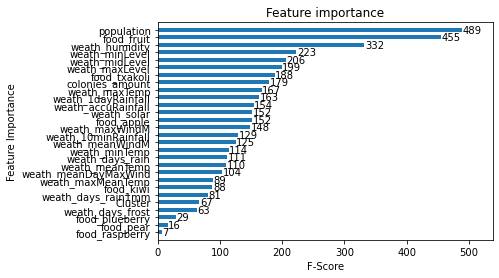

In [33]:
# Plot the Relevant Variables in order to filter the relevant ones per Cluster

plot_importance(model,height=0.5,xlabel="F-Score",ylabel="Feature Importance",grid=False)
plt.show()

In [34]:
# selecting the XGBoost model and fitting with the train data without the irrelevant variables
# selecting the train X & y variables

# selecting the train X & y variables

# Y/Response variable have been defined previously

# X will be the explanatory variables. Remove response variable and non desired categorical columns such as (municip code, year, etc...)
X = queen_train.loc[:,["population","food_fruit","weath_humidity","Cluster"]].copy()

# We want to predict our response variable (number of nests in 2020). Remove response variable and non desired categorical columns such as (municip code, year, etc...)
queen_predict2020 = queen_predict.loc[:,["population","food_fruit","weath_humidity","Cluster"]].copy()

### Choose a class of model by importing the appropriate estimator class

In [35]:
# selecting the XGBoost model and fitting with the train data

model = XGBRegressor()

### Fit the model to your data by calling the `.fit()` method of the model instance

In [36]:
# refitting the model

model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Apply the model to new data:

- For supervised learning, predict labels for unknown data using the `.predict()` method

In [37]:
# make a prediction

prediction_2020 = model.predict(queen_predict2020)

C:\Users\pgeir\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


## Add Each Cluster Predictions to the original DataFrame and Save it as a `.csv file`

In [38]:
# Create a new Column with the 2020 prediction
# Add the cluster predictions to the newly created column

queen_predict["nests_2020"] = prediction_2020

In [39]:
# group by municip code
group_predict = queen_predict.groupby(by=["municip_code","municip_name"], as_index=False).sum()

In [40]:
# Create a new DataFrame with the Municipalities to insert manualy

HEX_aux = pd.DataFrame({"CODIGO MUNICIPIO":[48022, 48071, 48088, 48074, 48051, 48020],\
             "NOMBRE MUNICIPIO":["Karrantza Harana/Valle de Carranza","Muskiz","Ubide","Urduña/Orduña","Lanestosa","Bilbao"],\
             "NIDOS 2020":[0,0,0,0,0,0]})

In [41]:
HEX = group_predict.loc[:,["municip_code","municip_name","nests_2020"]].round() # create a new Dataframe for Kopuru submission
HEX.columns = ["CODIGO MUNICIPIO","NOMBRE MUNICIPIO","NIDOS 2020"] # change column names to Spanish (Decidata template)
HEX = HEX.append(HEX_aux, ignore_index=True) # Add rows of municipalities to add manually

In [42]:
# Final check

check_data(HEX)

(112, 3) : Shape is correct.
112 : Number of unique municipalities is correct.
The Total 2020 Nests' Prediction is 3475


In [21]:
# Save the new dataFrame as a .csv in the current working directory on Windows

HEX.to_csv("WaspBusters_20210512_batch_XGmonths_ClusterVar.csv", index=False)